In [135]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [136]:
#Reading CSV's
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [137]:
#SalePrice Data Info
describe_train = train.SalePrice.describe()
describe_train

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Skew is:  1.8828757597682129


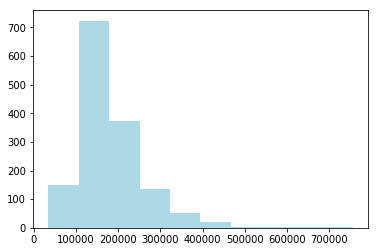

In [21]:
#Finding Train Skew
print ("Train skew: ", train.SalePrice.skew())
plt.hist(train.SalePrice, color='lightblue')
plt.show()

Target skew:  0.12133506220520406


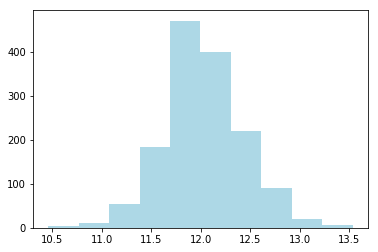

In [138]:
#Finding Target Skew
target = np.log(train.SalePrice)
print ("Target skew: ", target.skew())
plt.hist(target, color='lightblue')
plt.show()

In [139]:
#Finding Graph Correlations
numeric_features = train.select_dtypes(include=[np.number])
correlation = numeric_features.corr()
first_comparator = corr['SalePrice'].sort_values(ascending=False)[:5]
second_comparator = corr['SalePrice'].sort_values(ascending=False)[-5:]
print ("First values \n", first_comparator, "\n")
print ("Second values \n", second_comparator)

First values 
 SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64 

Second values 
 YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


In [140]:
#Categories
categories = train.select_dtypes(exclude=[np.number])
print (categories.describe())

       MSZoning Street Alley LotShape LandContour Utilities LotConfig  \
count      1460   1460    91     1460        1460      1460      1460   
unique        5      2     2        4           4         2         5   
top          RL   Pave  Grvl      Reg         Lvl    AllPub    Inside   
freq       1151   1454    50      925        1311      1459      1052   

       LandSlope Neighborhood Condition1      ...      GarageType  \
count       1460         1460       1460      ...            1379   
unique         3           25          9      ...               6   
top          Gtl        NAmes       Norm      ...          Attchd   
freq        1382          225       1260      ...             870   

       GarageFinish GarageQual GarageCond PavedDrive PoolQC  Fence  \
count          1379       1379       1379       1460      7    281   
unique            3          5          5          3      3      4   
top             Unf         TA         TA          Y     Gd  MnPrv   
freq    

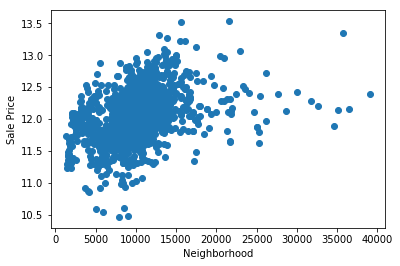

In [144]:
#Removing Outliers from Selected Index
train = train[train['LotArea'] < 40000]
plt.scatter(x = train['LotArea'], y = np.log(train.SalePrice))
plt.ylabel('Sale Price')
plt.xlabel('Neighborhood')
plt.show()

In [145]:
#Handling Nulls
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
print(nulls)

              Null Count
Feature                 
PoolQC              1436
MiscFeature         1391
Alley               1351
Fence               1161
FireplaceQu          689
LotFrontage          252
GarageCond            81
GarageType            81
GarageYrBlt           81
GarageFinish          81
GarageQual            81
BsmtExposure          38
BsmtFinType2          38
BsmtFinType1          37
BsmtCond              37
BsmtQual              37
MasVnrArea             8
MasVnrType             8
Electrical             1
Utilities              0
YearRemodAdd           0
MSSubClass             0
Foundation             0
ExterCond              0
ExterQual              0


In [146]:
#Hot Encoded Transformation
streetVal = train.Street.value_counts()
streetVal

Pave    1438
Grvl       4
Name: Street, dtype: int64

In [147]:
#Fitting Encoded Street Data Into Test and Train
train['enc_street'] = pd.get_dummies(train.Street, drop_first=True)
test['enc_street'] = pd.get_dummies(test.Street, drop_first=True)
train.enc_street.value_counts()

1    1438
0       4
Name: enc_street, dtype: int64

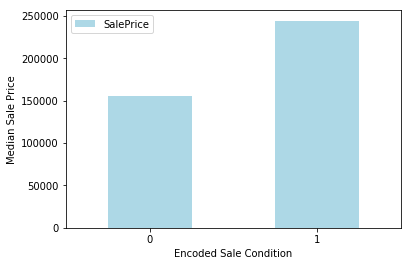

In [160]:
#Creating Encoding Function
def encode(x): return 1 if x == 'Partial' else 0
train['enc_condition'] = train.SaleCondition.apply(encode)
test['enc_condition'] = train.SaleCondition.apply(encode)

condition_pivot = train.pivot_table(index = 'enc_condition', values = 'SalePrice', aggfunc = np.median)
condition_pivot.plot(kind = 'bar', color = 'lightblue')
plt.xlabel('Encoded Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation = 0)
plt.show()

In [149]:
#Interpolate missing data with an average value
data = train.select_dtypes(include=[np.number]).interpolate().dropna()
print (sum(data.isnull().sum() != 0))

0


In [151]:
#Linear Model, Splitting the Test Size For a More Accurate Prediction
y = np.log(train.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33)
lr = linear_model.LinearRegression()

In [152]:
#Fitting the Linear Regression Model
lin_reg = lr.fit(X_train, y_train)

In [153]:
#Test
model = lin_reg.score(X_test, y_test)
model

0.8881056736200384

In [154]:
#Predictions, RMSE
y_pred = lin_reg.predict(X_test)
pred = mean_squared_error(y_test, y_pred)
pred

0.016225567643797446

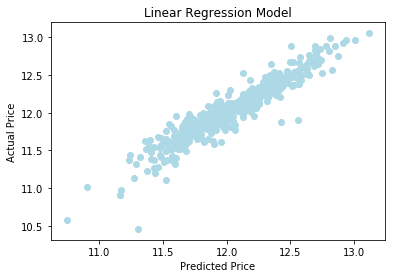

In [155]:
#Graphing the Model
val = y_test
plt.scatter(y_pred, val, color = 'lightblue')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

In [157]:
#Creating Final Predictions and the Data Frame to Submit
final = pd.DataFrame()
final['Id'] = test.Id
features = test.select_dtypes(include = [np.number]).drop(['Id'], axis = 1).interpolate()
predictions = lin_reg.predict(features)
final_predictions = np.exp(predictions)
print ("Original: ", predictions[:10], "\n")
print ("Final Predictions: ", final_predictions[:10])

Original:  [11.7187679  11.95681131 12.06957686 12.17091018 12.10950849 12.04666135
 12.12960964 11.99840249 12.16481455 11.64211616] 

Final Predictions:  [122855.96149467 155875.25382946 174481.99903266 193089.7098151
 181590.32847221 170529.11929514 185277.43748209 162494.99657133
 191916.28705173 113790.7094135 ]


In [158]:
final['SalePrice'] = final_predictions
final.to_csv('Submission1.csv', index=False)
final

,Id,SalePrice
0,1461,122855.961495
1,1462,155875.253829
2,1463,174481.999033
3,1464,193089.709815
4,1465,181590.328472
5,1466,170529.119295
6,1467,185277.437482
7,1468,162494.996571
8,1469,191916.287052
9,1470,113790.709414
